Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)



In [154]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('aac_shelter_outcomes.csv').iloc[:10000]
data.head()


,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [155]:
data = data[data['outcome_type'].isin(['Adoption', 'Transfer'])]
data['outcome_type']=(data['outcome_type'] == 'Adoption')*1
data['age_upon_outcome'] = (pd.to_datetime(data['datetime'])-pd.to_datetime(data['date_of_birth'])).dt.days
data['animal_type'].value_counts()
data['breed'].value_counts()
data['sex_upon_outcome'].value_counts(dropna=False)
data ['sex_upon_outcome']=data['sex_upon_outcome'].fillna('Unknown')
def split_sex(s):
    if s=='Unknown':
        return pd.Series([np.nan, np.nan], index=['sex', 'is_sterilized'])
    is_stirilized, sex = s.split()
    if is_stirilized =='Spayed' or 'Neutered':
        is_stirilized=1
    else:
        is_stirilized=0
    if sex=='Male':
        sex=1
    else:
        sex=0
    return pd.Series([sex, is_stirilized], index=['sex', 'is_sterilized'])
data[['sex', 'is_stirilized']] = data['sex_upon_outcome'].apply(split_sex).astype('Int64')

data=data.loc[data['age_upon_outcome']<200]
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,sex,is_stirilized
0,15,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,0,Intact Male,1,1
5,126,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,0,Intact Male,1,1
8,59,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16T00:00:00,2014-08-14T18:45:00,2014-08-14T18:45:00,Lucy,NaN,1,Intact Female,0,1
9,95,A678580,Cat,Domestic Shorthair Mix,White/Black,2014-03-26T00:00:00,2014-06-29T17:45:00,2014-06-29T17:45:00,*Frida,Offsite,1,Spayed Female,0,1
12,80,A677679,Dog,Chihuahua Shorthair/Pomeranian,Black,2014-03-07T00:00:00,2014-05-26T19:10:00,2014-05-26T19:10:00,Kash,Foster,1,Neutered Male,1,1


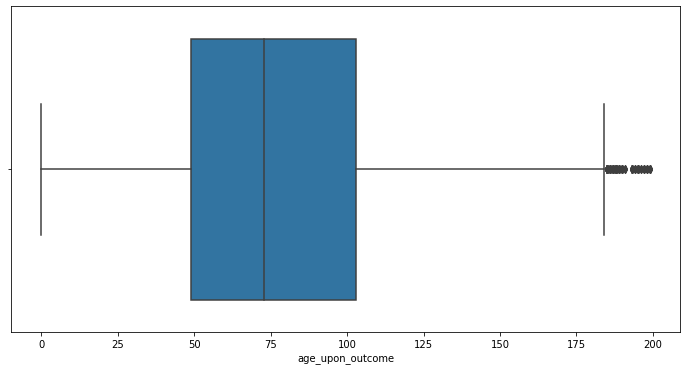

In [156]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data['age_upon_outcome'])

In [157]:
#data[data['usecode']=='Condominium']['bedrooms'].median()

In [158]:
data['animal_type'].value_counts()

Cat      2084
Dog      1136
Other      19
Bird       15
Name: animal_type, dtype: int64

In [159]:
data[data['animal_type']=='Cat']['age_upon_outcome'].median()

70.0

In [160]:
data[data['animal_type']=='Dog']['age_upon_outcome'].median()

80.0

In [161]:
data[data['animal_type']=='Bird']['age_upon_outcome'].median()

22.0

In [162]:
data[data['animal_type']=='Other']['age_upon_outcome'].median()

90.0

In [163]:
norma_age = data[data['age_upon_outcome']>190]
for types in norma_age['animal_type'].unique():
    data.loc[(data['animal_type']==types)&(data['age_upon_outcome']>190), 'age_upon_outcome'] = data[data['animal_type']==types]['age_upon_outcome'].median()
norma_age['animal_type'].value_counts()


Dog     24
Cat     21
Bird     1
Name: animal_type, dtype: int64

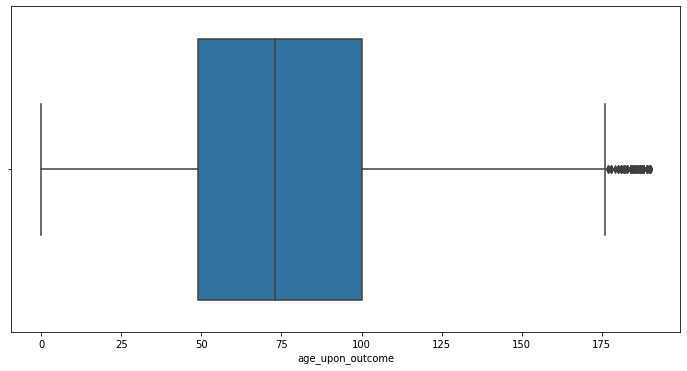

In [164]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data['age_upon_outcome'])

In [165]:
breed = data['breed'].value_counts()
breed_for = breed[breed<10].index
data.loc[data['breed'].isin(breed_for), 'breed'] = 'Mix'
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,sex,is_stirilized
0,15.0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,0,Intact Male,1,1
5,126.0,A664462,Dog,Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,0,Intact Male,1,1
8,59.0,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16T00:00:00,2014-08-14T18:45:00,2014-08-14T18:45:00,Lucy,NaN,1,Intact Female,0,1
9,95.0,A678580,Cat,Domestic Shorthair Mix,White/Black,2014-03-26T00:00:00,2014-06-29T17:45:00,2014-06-29T17:45:00,*Frida,Offsite,1,Spayed Female,0,1
12,80.0,A677679,Dog,Mix,Black,2014-03-07T00:00:00,2014-05-26T19:10:00,2014-05-26T19:10:00,Kash,Foster,1,Neutered Male,1,1


In [166]:
data['outcome_type'].value_counts()

1    1659
0    1595
Name: outcome_type, dtype: int64

CatBoost начинается здесь

In [167]:
x = data[['age_upon_outcome', 'animal_type', 'breed', 'color', 'sex', 'is_stirilized']]
y = data['outcome_type']
categoricals = ['animal_type', 'breed', 'color', 'sex', 'is_stirilized']
# нашли категориальные переменные, по которым будем предсказывать
#
x[categoricals] = x[categoricals].astype('object').fillna('NULL')
#почему если я добавляю фичу - медианы возраста по типу животного, бустинг уже не работает?

/Users/natalaurina/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [168]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=1995)
#чтобы причины случайной величины были всегда одинаковы(напрмер, дуновение ветра, тряска руки и тд)
cat_cols = np.where(x.columns.isin(categoricals))[0]
#x.columns - список наших колонок, isin - проверяем, находится ли элемент в списке (колонка, а не эл-т)
#np.where- чтобы узнать номера, а не булевые значеня
#[0] - чтобы возвращался не кортеж, а только номер из 1 числа

# 1 способ Catboost

In [170]:
clf = CatBoostClassifier(n_estimators=300, learning_rate=0.2, max_depth=5, cat_features=cat_cols, eval_metric='AUC')
clf.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], silent=True)
y_pred_train, y_pred_test = clf.predict_proba(x_train)[:, 1], clf.predict_proba(x_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train), roc_auc_score(y_test, y_pred_test))

0.8967842965196469 0.8750753012048192


# 2 способ LogisticRegression

In [171]:
#onehot encoding!
x = pd.get_dummies(x, columns=categoricals) 


In [172]:
x.shape

(3254, 204)

In [173]:
#Логистическая регрессия со стандартизацией данных
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=31)
pipe=Pipeline([['scaler', StandardScaler()], ['logistic', LogisticRegression(solver='lbfgs', max_iter=1000)] ])
pipe.fit(x_train, y_train) # Обучение

y_pred_test = estimator.predict(x_test)

y_pred_train = estimator.predict(x_train)

print(roc_auc_score(y_train, y_pred_train), roc_auc_score(y_test, y_pred_test))

0.7019727076594976 0.6544029977857264


# 3 способо RandomForest

In [175]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=31)
pipe=Pipeline([['random', RandomForestClassifier(n_estimators=1000)]])
pipe.fit(x_train, y_train) # Обучение

y_pred_test = estimator.predict(x_test)

y_pred_train = estimator.predict(x_train)

print(roc_auc_score(y_train, y_pred_train), roc_auc_score(y_test, y_pred_test))

0.7019727076594976 0.6544029977857264
